In [1]:
##https://rviews.rstudio.com/2017/09/25/survival-analysis-with-r/
library(survival)
library(ranger)
library(ggplot2)
library(dplyr)
library(ggfortify)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#------------
data(veteran)
head(veteran)

Warning message in data(veteran):
“data set ‘veteran’ not found”


,trt,celltype,time,status,karno,diagtime,age,prior
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,squamous,72,1,60,7,69,0
2,1,squamous,411,1,70,5,64,10
3,1,squamous,228,1,60,3,38,0
4,1,squamous,126,1,60,9,63,10
5,1,squamous,118,1,70,11,65,10
6,1,squamous,10,1,20,5,49,0


# Kaplan Meier

In [3]:
# Kaplan Meier Survival Curve
km <- with(veteran, Surv(time, status))
head(km,80)

 [1]  72  411  228  126  118   10   82  110  314  100+  42    8  144   25+  11 
[16]  30  384    4   54   13  123+  97+ 153   59  117   16  151   22   56   21 
[31]  18  139   20   31   52  287   18   51  122   27   54    7   63  392   10 
[46]   8   92   35  117  132   12  162    3   95  177  162  216  553  278   12 
[61] 260  200  156  182+ 143  105  103  250  100  999  112   87+ 231+ 242  991 
[76] 111    1  587  389   33 

In [4]:
km_fit <- survfit(Surv(time, status) ~ 1, data=veteran)
summary(km_fit, times = c(1,30,60,90*(1:10)))

Call: survfit(formula = Surv(time, status) ~ 1, data = veteran)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    137       2    0.985  0.0102      0.96552       1.0000
   30     97      39    0.700  0.0392      0.62774       0.7816
   60     73      22    0.538  0.0427      0.46070       0.6288
   90     62      10    0.464  0.0428      0.38731       0.5560
  180     27      30    0.222  0.0369      0.16066       0.3079
  270     16       9    0.144  0.0319      0.09338       0.2223
  360     10       6    0.090  0.0265      0.05061       0.1602
  450      5       5    0.045  0.0194      0.01931       0.1049
  540      4       1    0.036  0.0175      0.01389       0.0934
  630      2       2    0.018  0.0126      0.00459       0.0707
  720      2       0    0.018  0.0126      0.00459       0.0707
  810      2       0    0.018  0.0126      0.00459       0.0707
  900      2       0    0.018  0.0126      0.00459       0.0707

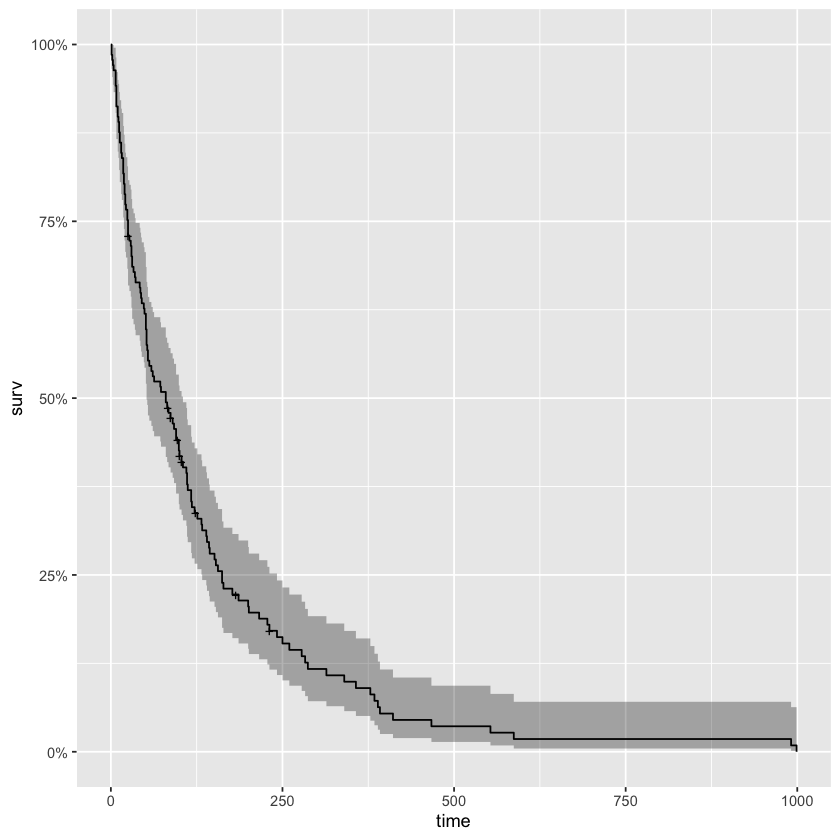

In [5]:
#plot(km_fit, xlab="Days", main = 'Kaplan Meyer Plot') #base graphics is always ready
autoplot(km_fit)

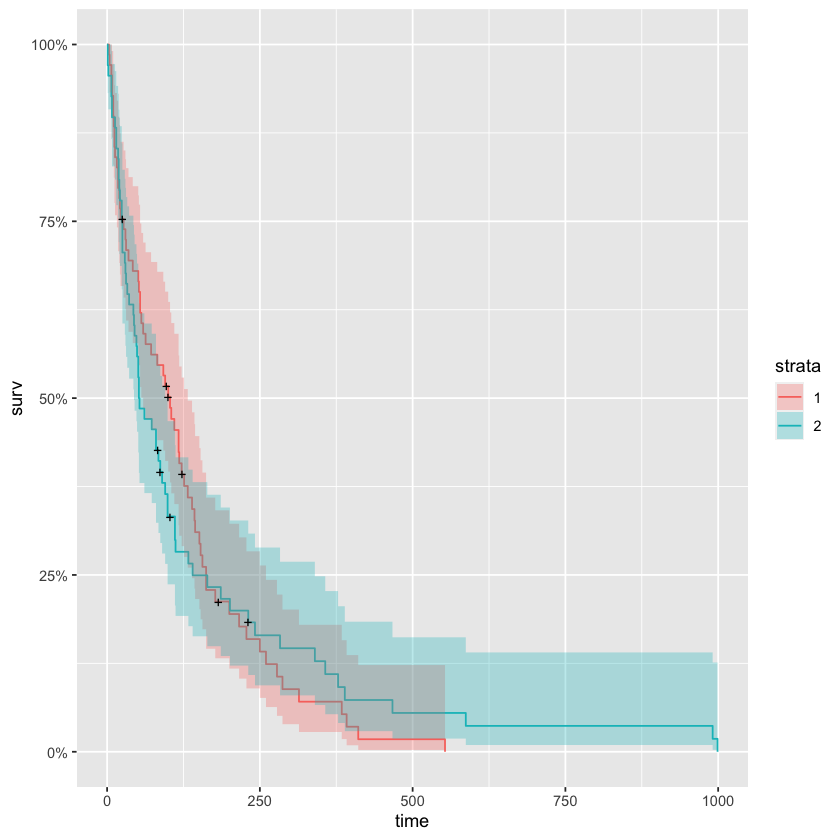

In [6]:
km_trt_fit <- survfit(Surv(time, status) ~ trt, data=veteran)
autoplot(km_trt_fit)

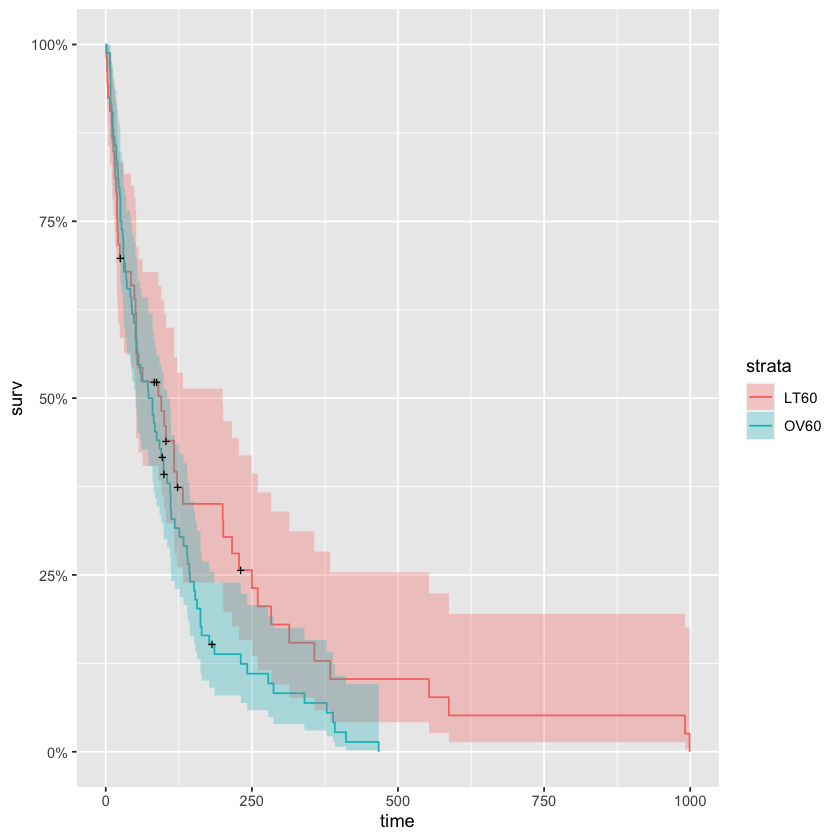

In [7]:
vet <- mutate(veteran, AG = ifelse((age < 60), "LT60", "OV60"),
              AG = factor(AG),
              trt = factor(trt,labels=c("standard","test")),
              prior = factor(prior,labels=c("N0","Yes")))

km_AG_fit <- survfit(Surv(time, status) ~ AG, data=vet)
autoplot(km_AG_fit)

# Cox Proportional Hazards Model


In [8]:
# Fit Cox Model
cox <- coxph(Surv(time, status) ~ trt + celltype + karno + diagtime + age + prior , data = vet)
summary(cox)

Call:
coxph(formula = Surv(time, status) ~ trt + celltype + karno + 
    diagtime + age + prior, data = vet)

  n= 137, number of events= 128 

                        coef  exp(coef)   se(coef)      z Pr(>|z|)    
trttest            2.946e-01  1.343e+00  2.075e-01  1.419  0.15577    
celltypesmallcell  8.616e-01  2.367e+00  2.753e-01  3.130  0.00175 ** 
celltypeadeno      1.196e+00  3.307e+00  3.009e-01  3.975 7.05e-05 ***
celltypelarge      4.013e-01  1.494e+00  2.827e-01  1.420  0.15574    
karno             -3.282e-02  9.677e-01  5.508e-03 -5.958 2.55e-09 ***
diagtime           8.132e-05  1.000e+00  9.136e-03  0.009  0.99290    
age               -8.706e-03  9.913e-01  9.300e-03 -0.936  0.34920    
priorYes           7.159e-02  1.074e+00  2.323e-01  0.308  0.75794    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                  exp(coef) exp(-coef) lower .95 upper .95
trttest              1.3426     0.7448    0.8939    2.0166
celltypesmallcell    2.3669    

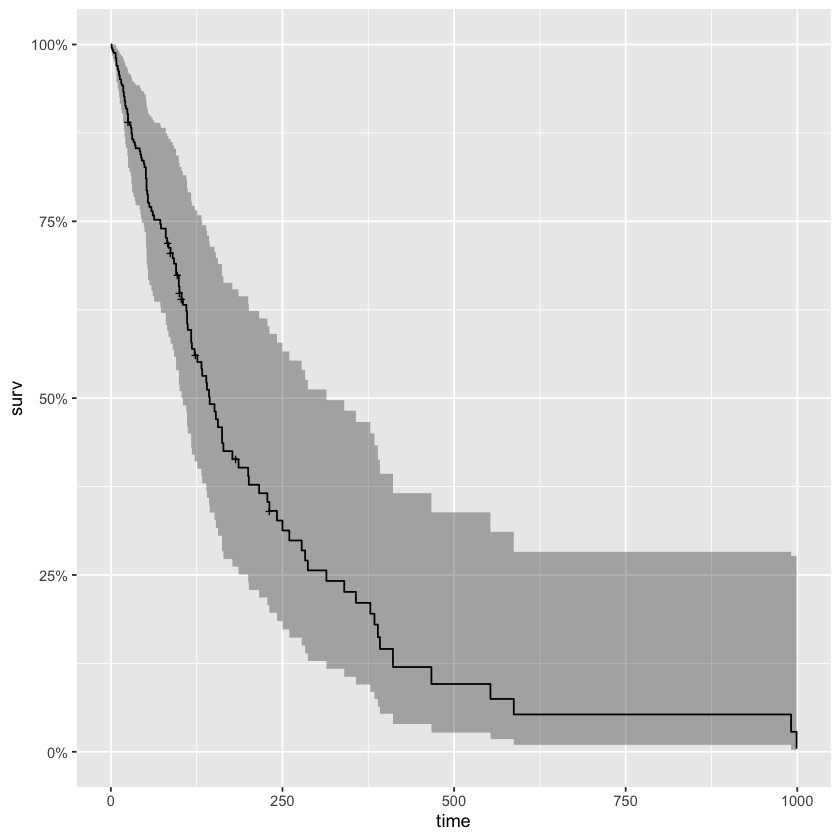

In [9]:
cox_fit <- survfit(cox)
#plot(cox_fit, main = "cph model", xlab="Days")
autoplot(cox_fit)

In [10]:
aa_fit <-aareg(Surv(time, status) ~ trt + celltype +
                 karno + diagtime + age + prior , 
                 data = vet)
aa_fit

Call:
aareg(formula = Surv(time, status) ~ trt + celltype + karno + 
    diagtime + age + prior, data = vet)

  n= 137 
    75 out of 97 unique event times used

                      slope      coef se(coef)      z        p
Intercept          0.083400  3.81e-02 1.09e-02  3.490 4.79e-04
trttest            0.006730  2.49e-03 2.58e-03  0.967 3.34e-01
celltypesmallcell  0.015000  7.30e-03 3.38e-03  2.160 3.09e-02
celltypeadeno      0.018400  1.03e-02 4.20e-03  2.450 1.42e-02
celltypelarge     -0.001090 -6.21e-04 2.71e-03 -0.229 8.19e-01
karno             -0.001180 -4.37e-04 8.77e-05 -4.980 6.28e-07
diagtime          -0.000243 -4.92e-05 1.64e-04 -0.300 7.65e-01
age               -0.000246 -6.27e-05 1.28e-04 -0.491 6.23e-01
priorYes           0.003300  1.54e-03 2.86e-03  0.539 5.90e-01

Chisq=41.62 on 8 df, p=1.6e-06; test weights=aalen

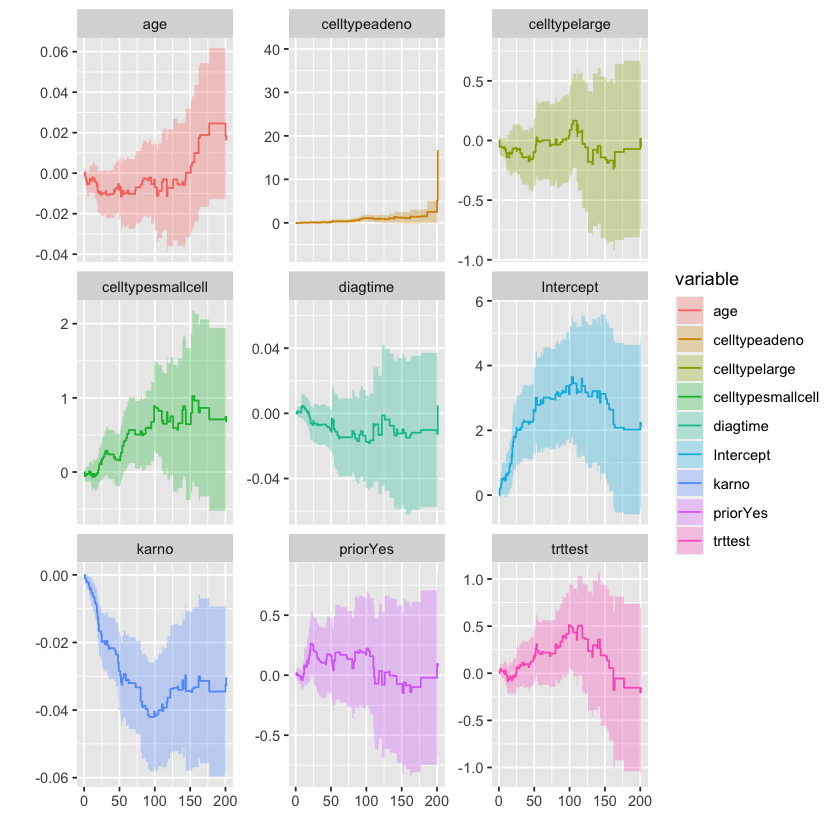

In [11]:
#summary(aa_fit)  # provides a more complete summary of results
autoplot(aa_fit)

# Random Forests Model


In [12]:
# ranger model
r_fit <- ranger(Surv(time, status) ~ trt + celltype + 
                     karno + diagtime + age + prior,
                     data = vet,
                     mtry = 4,
                     importance = "permutation",
                     splitrule = "extratrees",
                     verbose = TRUE)

In [13]:
# Average the survival models
death_times <- r_fit$unique.death.times 
surv_prob <- data.frame(r_fit$survival)
avg_prob <- sapply(surv_prob,mean)

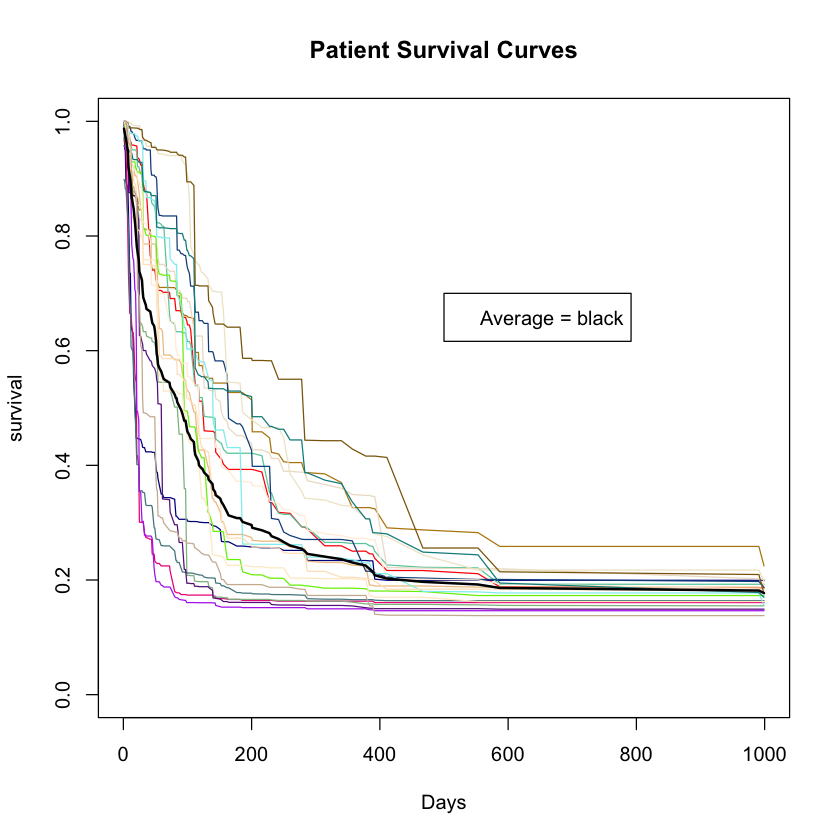

In [17]:
# Plot the survival models for each patient
plot(r_fit$unique.death.times,r_fit$survival[1,], 
     type = "l", 
     ylim = c(0,1),
     col = "red",
     xlab = "Days",
     ylab = "survival",
     main = "Patient Survival Curves")
#
cols <- colors()
for (n in sample(c(2:dim(vet)[1]), 20)){
  lines(r_fit$unique.death.times, r_fit$survival[n,], type = "l", col = cols[n])
}

lines(death_times, avg_prob, lwd = 2)
legend(500, 0.7, legend = c('Average = black'))


In [18]:
vi <- data.frame(sort(round(r_fit$variable.importance, 4), decreasing = TRUE))
names(vi) <- "importance"
head(vi)

,importance
,<dbl>
karno,0.0931
celltype,0.0320
trt,0.0031
diagtime,0.0011
prior,-0.0010
age,-0.0028


In [19]:
cat("Prediction Error = 1 - Harrell's c-index = ", r_fit$prediction.error)


Prediction Error = 1 - Harrell's c-index =  0.3034984

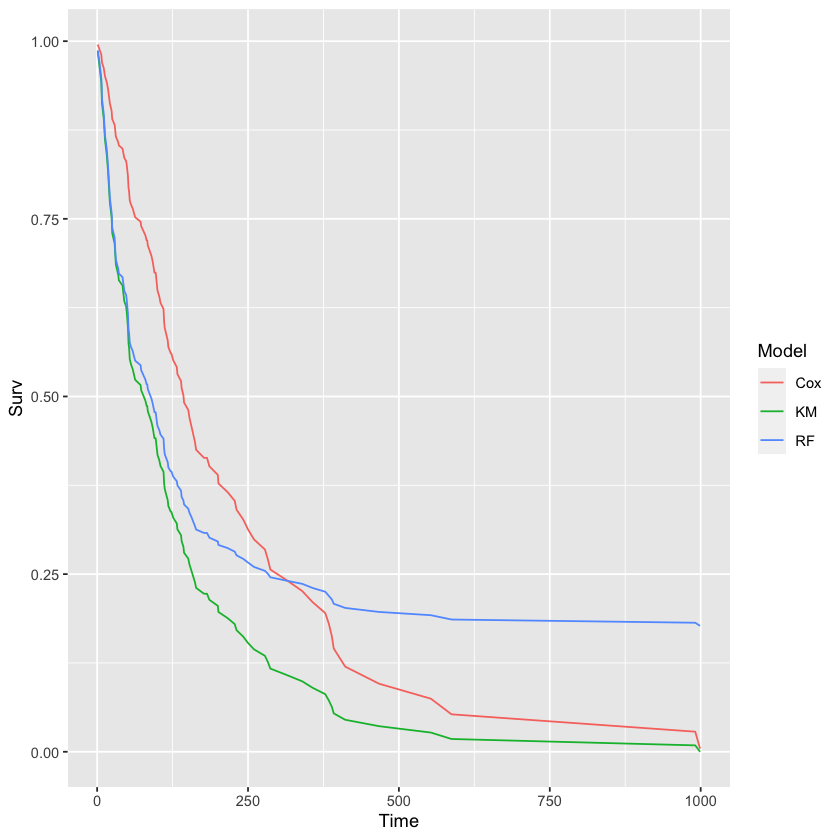

In [20]:
# Set up for ggplot
kmi <- rep("KM",length(km_fit$time))
km_df <- data.frame(km_fit$time,km_fit$surv,kmi)
names(km_df) <- c("Time","Surv","Model")

coxi <- rep("Cox",length(cox_fit$time))
cox_df <- data.frame(cox_fit$time,cox_fit$surv,coxi)
names(cox_df) <- c("Time","Surv","Model")

rfi <- rep("RF",length(r_fit$unique.death.times))
rf_df <- data.frame(r_fit$unique.death.times,avg_prob,rfi)
names(rf_df) <- c("Time","Surv","Model")

plot_df <- rbind(km_df,cox_df,rf_df)

p <- ggplot(plot_df, aes(x = Time, y = Surv, color = Model))
p + geom_line()